In [1]:
import pandas as pd

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench301'

In [2]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores

search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [3]:
dataset = 'cifar10'
data = dfs[dataset]

In [4]:
from naslib.search_spaces.nasbench301.conversions import convert_compact_to_genotype
from zc_combine.features.conversions import darts_to_graph


def get_darts_net(n):
    genotype = convert_compact_to_genotype(eval(n))
    return darts_to_graph(genotype.normal), darts_to_graph(genotype.reduce)

In [5]:
nets = {i: get_darts_net(data.loc[i]['net']) for i in data.index}

In [38]:
import json

with open('../zc_combine/configs/nb301_first.json', 'r') as f:
    cfg = json.load(f)

In [39]:
from zc_combine.features.darts import feature_func_dict
from zc_combine.features.dataset import get_feature_dataset

feature_dataset = get_feature_dataset(nets, cfg, feature_func_dict)
feature_dataset.keys()

dict_keys(['op_count', 'min_path_len', 'max_op_on_path', 'node_degree'])

In [40]:
features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
dataset = pd.concat([feature_dataset[f] for f in features], axis=1)
dataset['val_accs'] = data['val_accs']
dataset

/tmp/ipykernel_19971/298988611.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['val_accs'] = data['val_accs']


,op_count_normal_0,op_count_normal_1,op_count_normal_2,op_count_normal_3,op_count_normal_4,op_count_normal_5,op_count_normal_6,op_count_normal_7,op_count_reduce_0,op_count_reduce_1,...,"node_degree_allowed_[1, 2, 3]_normal_c_{k-1}_degree","node_degree_allowed_[1, 2, 3]_normal_out_degree","node_degree_allowed_[1, 2, 3]_normal_avg_in","node_degree_allowed_[1, 2, 3]_normal_avg_out","node_degree_allowed_[1, 2, 3]_reduce_c_{k-2}_degree","node_degree_allowed_[1, 2, 3]_reduce_c_{k-1}_degree","node_degree_allowed_[1, 2, 3]_reduce_out_degree","node_degree_allowed_[1, 2, 3]_reduce_avg_in","node_degree_allowed_[1, 2, 3]_reduce_avg_out",val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,4,1,0,2,0,2,1,2,4,0,...,0,0,0.428571,0.428571,2,0,0,0.428571,0.428571,93.459999
1,4,2,0,1,1,1,2,1,4,2,...,1,0,0.428571,0.428571,0,1,0,0.428571,0.428571,92.790001
2,4,4,0,1,1,1,0,1,4,1,...,2,0,0.714286,0.714286,0,3,0,0.571429,0.571429,93.320000
3,4,2,1,0,2,1,2,0,4,4,...,0,0,0.428571,0.428571,2,2,0,0.857143,0.857143,92.809998
4,4,1,2,1,1,1,1,1,4,1,...,0,0,0.571429,0.571429,2,1,0,0.714286,0.714286,92.919998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11216,4,1,0,0,0,0,4,3,4,0,...,1,0,0.142857,0.142857,0,1,0,0.285714,0.285714,92.919998
11217,4,0,1,0,1,4,0,2,4,1,...,0,0,0.142857,0.142857,2,0,0,0.428571,0.428571,92.750000
11218,4,3,0,0,0,2,2,1,4,2,...,1,0,0.428571,0.428571,2,0,0,0.714286,0.714286,92.080002


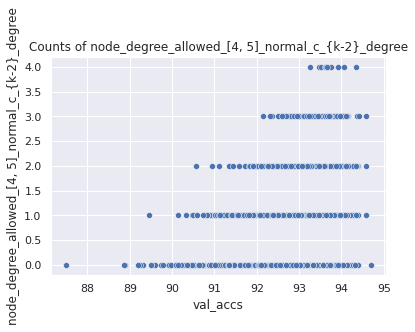

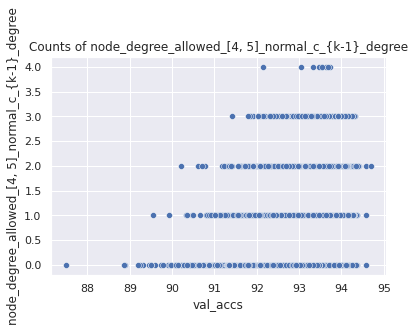

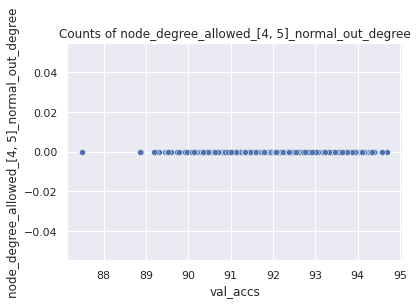

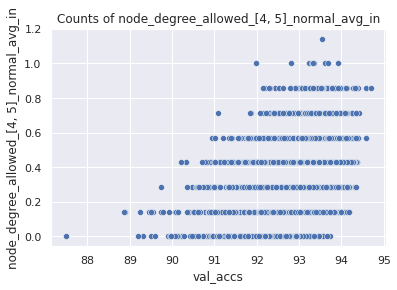

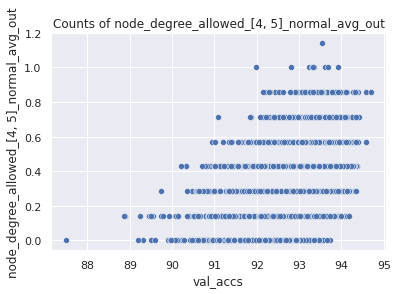

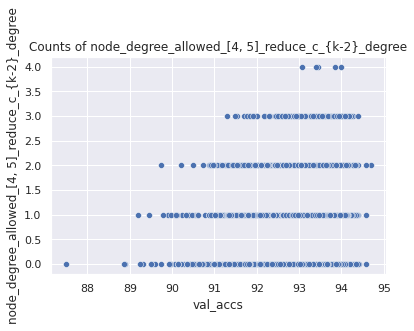

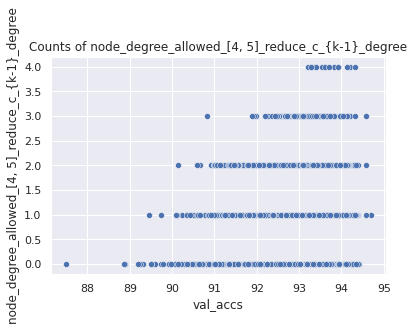

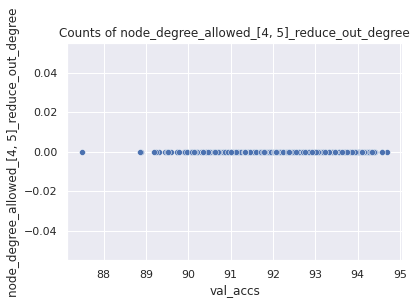

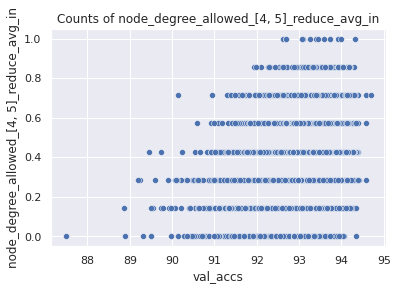

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = feature_dataset['node_degree'].copy()
plot_df['val_accs'] = data['val_accs']

import os
#os.mkdir('tmp')

max_plots = 8

for i, c in enumerate(plot_df.columns):
    if c == 'val_accs' or i > max_plots:
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [41]:
proxy_cols = [c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]


def get_dataset(feature_dfs, proxy_df, features, cols):
    feat_dfs = [feature_dfs[f] for f in features]
    prox_df = proxy_df[cols]

    res_data = pd.concat([*feat_dfs, prox_df], axis=1)

    y = proxy_df['val_accs'].loc[res_data.index]
    if 'val_accs' in res_data:
        res_data.drop(columns=['val_accs'], inplace=True)

    return res_data, y

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
full_data, full_y = get_dataset(feature_dataset, data, features, ['flops', 'params'])
print(full_data.shape)
full_data

(11221, 328)


,op_count_normal_0,op_count_normal_1,op_count_normal_2,op_count_normal_3,op_count_normal_4,op_count_normal_5,op_count_normal_6,op_count_normal_7,op_count_reduce_0,op_count_reduce_1,...,"node_degree_allowed_[1, 2, 3]_normal_out_degree","node_degree_allowed_[1, 2, 3]_normal_avg_in","node_degree_allowed_[1, 2, 3]_normal_avg_out","node_degree_allowed_[1, 2, 3]_reduce_c_{k-2}_degree","node_degree_allowed_[1, 2, 3]_reduce_c_{k-1}_degree","node_degree_allowed_[1, 2, 3]_reduce_out_degree","node_degree_allowed_[1, 2, 3]_reduce_avg_in","node_degree_allowed_[1, 2, 3]_reduce_avg_out",flops,params
0,4,1,0,2,0,2,1,2,4,0,...,0,0.428571,0.428571,2,0,0,0.428571,0.428571,169.285120,0.963882
1,4,2,0,1,1,1,2,1,4,2,...,0,0.428571,0.428571,0,1,0,0.428571,0.428571,166.336000,0.958442
2,4,4,0,1,1,1,0,1,4,1,...,0,0.714286,0.714286,0,3,0,0.571429,0.571429,145.413632,0.788522
3,4,2,1,0,2,1,2,0,4,4,...,0,0.428571,0.428571,2,2,0,0.857143,0.857143,157.939200,0.852778
4,4,1,2,1,1,1,1,1,4,1,...,0,0.571429,0.571429,2,1,0,0.714286,0.714286,152.385024,0.839978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11216,4,1,0,0,0,0,4,3,4,0,...,0,0.142857,0.142857,0,1,0,0.285714,0.285714,167.384576,0.980650
11217,4,0,1,0,1,4,0,2,4,1,...,0,0.142857,0.142857,2,0,0,0.428571,0.428571,209.344000,1.188458
11218,4,3,0,0,0,2,2,1,4,2,...,0,0.428571,0.428571,2,0,0,0.714286,0.714286,155.719168,0.827242
11219,4,1,1,1,0,1,1,3,4,0,...,0,0.428571,0.428571,1,2,0,0.714286,0.714286,150.967808,0.821162


In [232]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def get_splits(fd, fy, train_size=100, seed=42):
    return train_test_split(fd, fy, random_state=seed, train_size=train_size)

def eval_rf(trx, tex, tryy, tey, n_times=1, random_state=43, **kwargs):
    res = {'score': [], 'tau': [], 'corr': []}
    rfs = []
    for i in range(n_times):
        rf = RandomForestRegressor(random_state=random_state + i, **kwargs)
        rf.fit(trx, tryy)
        res['score'].append(rf.score(tex, tey))

        preds = rf.predict(tex)
        res['tau'].append(kendalltau(preds, tey)[0])
        res['corr'].append(spearmanr(preds, tey)[0])
        rfs.append(rf)

    return rfs, res

def print_means(res):
    print(", ".join([f"{k}: {np.mean(v)}" for k, v in res.items()]))

In [118]:
import numpy as np

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
seed = 44
for ts in [100, 200, 1000]:
    print(f"Train size {ts}")
    for prox in proxy_cols:
        for include_fp in [True, False]:
            if prox in ['flops', 'params']:
                continue
            print(prox, "" if include_fp else " no fp")

            plist = ['flops', 'params', prox] if include_fp else [prox]
            fd, fy = get_dataset(feature_dataset, data, features, plist)
            data_splits = get_splits(fd, fy, train_size=ts, seed=seed)

            _, res = eval_rf(*data_splits, n_times=5)
            print_means(res)
            print()

Train size 100
val_accs 
score: 0.7512829775390143, tau: 0.6970363776793916, corr: 0.8776543958853369

val_accs  no fp
score: 0.7360810494743131, tau: 0.6893816926090557, corr: 0.8699675312225723

epe_nas 
score: 0.7472854676112235, tau: 0.6952472838279461, corr: 0.8767828697535001

epe_nas  no fp
score: 0.7324450575344339, tau: 0.6877760326317837, corr: 0.8686774994082599

fisher 
score: 0.7659636224017637, tau: 0.702344343985691, corr: 0.8805688993254177

fisher  no fp
score: 0.7636676712532078, tau: 0.7065727082860999, corr: 0.8816568518214533

grad_norm 
score: 0.7699126822566068, tau: 0.7062463324025086, corr: 0.8834239847563914

grad_norm  no fp
score: 0.7655785867844825, tau: 0.7099630030684142, corr: 0.8842132848830853

grasp 
score: 0.7464000553481359, tau: 0.6950797032619008, corr: 0.8763060136371802

grasp  no fp
score: 0.7472903496255058, tau: 0.6986531361933259, corr: 0.8769258015496512

jacov 
score: 0.8138474588065833, tau: 0.7361350452721762, corr: 0.905466291279202

ja

In [12]:
len(data)

11221

In [242]:
ts = 100
seed = 50

all_proxies = False
prox_to_include = []
prox_to_include = ['nwot', 'fisher']
with_features = True

features = ['op_count', 'max_op_on_path', 'node_degree']
feat_list = features if with_features else []

# proxies to add to data
def_proxlist = ['params', 'flops'] if prox_to_include is None else ['params', 'flops', *prox_to_include]
prox_list = proxy_cols if all_proxies else def_proxlist

fd, fy = get_dataset(feature_dataset, data, feat_list, prox_list)
fd = fd[[c for c in fd.columns if 'avg' not in c]]
#fd = fd[[c for c in fd.columns if c in topcols['feat'].to_numpy()]]
train_X, test_X, train_y, test_y = get_splits(fd, fy, train_size=ts, seed=seed)

rfs, res = eval_rf(train_X, test_X, train_y, test_y, n_times=5, n_estimators=100)
print_means(res)
rf_fitted = rfs[0]
preds = rf_fitted.predict(fd)
preds

score: 0.4554391703464642, tau: 0.5216537768052427, corr: 0.7142215978053723


array([93.31959991, 92.62480019, 92.77390083, ..., 92.16270004,
       93.01469978, 93.11779984])

In [243]:
trainpreds = rf_fitted.predict(train_X)
testpreds = rf_fitted.predict(test_X)

In [45]:
import sklearn

va, nw = data['val_accs'], data['nwot']
kendalltau(va, nw)[0], spearmanr(va, nw)[0]

(0.3271026492340012, 0.4729313017917638)

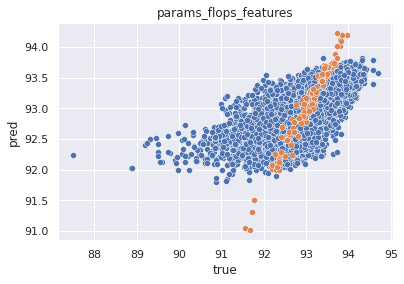

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt


#sns.scatterplot(data=data, x='val_accs', y='grad_norm')
#plt.show()
sns.scatterplot(data=pd.DataFrame({'pred': testpreds, 'true': test_y}), x='true', y='pred')
#sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': fy}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': train_y}), x='pred', y='true')
#plt.ylim(70, 95)

plt_name = f"{'all_proxies' if all_proxies else 'params_flops'}_{'features' if with_features else 'no_features'}"
plt.title(plt_name)
#plt.savefig(f"tmp/{plt_name}.png")
plt.show()

In [212]:
dcopy = data.copy()
dcopy['preds'] = preds
dcopy[['net', 'preds', 'val_accs']]

,net,preds,val_accs
0,"(((0, 6), (1, 4), (0, 0), (1, 5), (1, 4), (3, ...",93.319600,93.459999
1,"(((0, 4), (1, 5), (0, 6), (2, 2), (1, 0), (3, ...",92.624800,92.790001
2,"(((0, 4), (1, 6), (0, 2), (1, 0), (0, 0), (1, ...",92.773901,93.320000
3,"(((0, 3), (1, 3), (0, 5), (2, 0), (2, 1), (3, ...",92.739000,92.809998
4,"(((0, 6), (1, 4), (0, 3), (2, 2), (0, 0), (3, ...",92.931000,92.919998
...,...,...,...
11216,"(((0, 6), (1, 5), (0, 5), (2, 5), (1, 0), (3, ...",92.811600,92.919998
11217,"(((0, 6), (1, 4), (0, 4), (2, 3), (2, 4), (3, ...",93.205400,92.750000
11218,"(((0, 5), (1, 0), (0, 4), (2, 6), (2, 4), (3, ...",92.162700,92.080002
11219,"(((0, 6), (1, 5), (0, 0), (1, 6), (0, 2), (2, ...",93.014700,92.550003


In [230]:
nets[10744], nets[5198], nets[9950]

((({0: 'out',
    1: 'max_pool_3x3',
    2: 'avg_pool_3x3',
    3: 'skip_connect',
    4: 'sep_conv_3x3',
    5: 'sep_conv_5x5',
    6: 'dil_conv_3x3',
    7: 'dil_conv_5x5'},
   {('c_{k-2}', '0'): 1,
    ('c_{k-1}', '0'): 7,
    ('c_{k-2}', '1'): 3,
    ('c_{k-1}', '1'): 2,
    ('c_{k-2}', '2'): 5,
    ('c_{k-1}', '2'): 4,
    ('0', '3'): 5,
    ('2', '3'): 4,
    ('0', 'c_{k}'): 0,
    ('1', 'c_{k}'): 0,
    ('2', 'c_{k}'): 0,
    ('3', 'c_{k}'): 0}),
  ({0: 'out',
    1: 'max_pool_3x3',
    2: 'avg_pool_3x3',
    3: 'skip_connect',
    4: 'sep_conv_3x3',
    5: 'sep_conv_5x5',
    6: 'dil_conv_3x3',
    7: 'dil_conv_5x5'},
   {('c_{k-2}', '0'): 6,
    ('c_{k-1}', '0'): 3,
    ('c_{k-2}', '1'): 3,
    ('c_{k-1}', '1'): 4,
    ('0', '2'): 6,
    ('1', '2'): 4,
    ('c_{k-1}', '3'): 7,
    ('0', '3'): 1,
    ('0', 'c_{k}'): 0,
    ('1', 'c_{k}'): 0,
    ('2', 'c_{k}'): 0,
    ('3', 'c_{k}'): 0})),
 (({0: 'out',
    1: 'max_pool_3x3',
    2: 'avg_pool_3x3',
    3: 'skip_connect',
    4:

In [215]:
imps = rf_fitted.feature_importances_

imps = pd.DataFrame({"importance": imps, "feat": fd.columns})
imps

,importance,feat
0,0.000000,op_count_normal_0
1,0.088804,op_count_normal_1
2,0.005052,op_count_normal_2
3,0.017821,op_count_normal_3
4,0.003882,op_count_normal_4
...,...,...
145,0.000000,"node_degree_allowed_[1, 2, 3]_reduce_out_degree"
146,0.098701,params
147,0.031688,flops
148,0.095803,nwot


In [167]:
topcols = imps.sort_values('importance', ascending=False)[:20]
topcols

,importance,feat
146,0.098701,params
148,0.095803,nwot
1,0.088804,op_count_normal_1
67,0.035761,"max_op_on_path_allowed_[1, 2, 3]_reduce_c_{k-1}"
147,0.031688,flops
149,0.027965,fisher
66,0.024331,"max_op_on_path_allowed_[1, 2, 3]_reduce_c_{k-2}"
61,0.024306,"max_op_on_path_allowed_[1, 2]_normal_c_{k-1}"
60,0.024133,"max_op_on_path_allowed_[1, 2]_normal_c_{k-2}"
128,0.022961,node_degree_allowed_[3]_normal_c_{k-2}_degree


In [226]:
from sklearn.decomposition import PCA

pca_data = fd#data[proxy_cols]
pca = PCA(n_components=2)
pca_data = pca.fit_transform(pca_data)
pca_data

array([[  6.00268168,   2.97646116],
       [  4.88673109,  -1.08110163],
       [-18.60925814,   1.61897965],
       ...,
       [ -8.52537643,   4.466439  ],
       [-11.21619951,   1.54004591],
       [  1.27934314,  -2.09898613]])

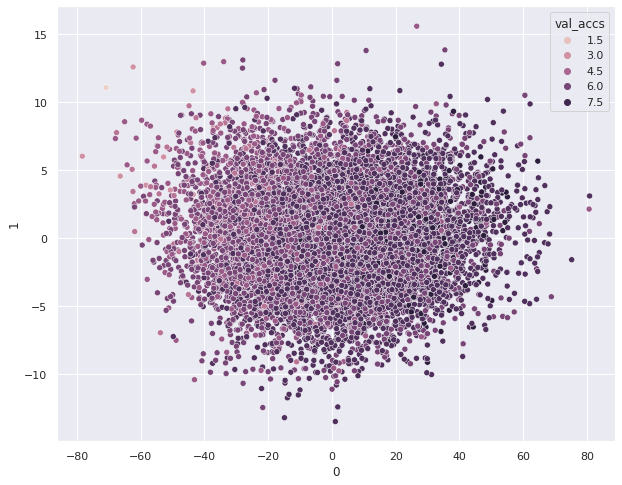

In [228]:
val_accss = data['val_accs'].to_numpy()
plot_dd = pd.DataFrame(pca_data)
plot_dd['val_accs'] = (val_accss - 86) // 1


plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
#plt.xlim(-2000, 5000)
plt.show()

In [124]:
# IDEA ... sample different nets based on clustering (max distance between nets...)

In [125]:
pd.DataFrame({'pred': preds, 'true': y, 'net': data['net']})

NameError: name 'y' is not defined

In [ ]:
from scipy.stats import kendalltau, spearmanr

kendalltau(preds, dsy)[0], spearmanr(preds, dsy)[0]

In [757]:
# TODO ruzny pocty siti
# where to sample... important
# TODO predikovat pres proxyny

# TODO vyplot predikci jen pres flops/params
# ... try that on transnb101

In [ ]:
#Next steps:

# TODO lepsi nazvy sloupecku, to str
# TODO fce co to spocita a da do df (myslim ty edge_path_op atd)
# TODO predikce - pres ruzny seedy, mozna crossval
# TODO porovnani s proxynama a bez, xgboost,...
# TODO tnb101

# TODO ruzny dalsi features...